In [62]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import plotly.graph_objects as go
import seaborn as sns
import pandas as pd
import geopandas as gpd
import datetime
import string
import random
import pymongo
import folium
import math
from pymongo import MongoClient
from typing import Union,List, Dict, Any
from shapely.geometry import Point
from geopy.distance import great_circle
from typing import Tuple



# Crear una conexión a una instancia de MongoDB en la dirección 'localhost:27017'.
data_mongo: MongoClient = pymongo.MongoClient('localhost', 27017)

# Seleccionar una base de datos existente o crear una nueva llamada 'test'.
db: pymongo.database.Database = data_mongo['test']

# Seleccionar una colección de la base de datos llamada 'datarows'.
rows: pymongo.collection.Collection = db['datarows']

In [63]:
# Obtener los n documentos de la colección y convertirlos a un DataFrame de Pandas.
drow1: pd.DataFrame = pd.json_normalize(list(rows.find()[:150000]), sep='_')
drow2: pd.DataFrame = pd.json_normalize(list(rows.find()[150000:300000]), sep='_')
drow3: pd.DataFrame = pd.json_normalize(list(rows.find()[300000:450000]), sep='_')
drow4: pd.DataFrame = pd.json_normalize(list(rows.find()[450000:600000]), sep='_')
drow5: pd.DataFrame = pd.json_normalize(list(rows.find()[600000:750000]), sep='_')
drow6: pd.DataFrame = pd.json_normalize(list(rows.find()[750000:900000]), sep='_')
drow7: pd.DataFrame = pd.json_normalize(list(rows.find()[900000:1050000]), sep='_')
drow8: pd.DataFrame = pd.json_normalize(list(rows.find()[1050000:1200000]), sep='_')
drow9: pd.DataFrame = pd.json_normalize(list(rows.find()[1200000:]), sep='_')

# Concatenar todos los DataFrames en un solo DataFrame.
df_row: pd.DataFrame = pd.concat([drow1, drow2, drow3, drow4, drow5, drow6, drow7, drow8, drow9], axis=0)

# Imprimir la forma (número de filas y columnas) del DataFrame resultante.
print(df_row.shape)

(1296780, 22)


In [64]:
def save_to_csv(df_row: pd.DataFrame):
    """
    Se guarda el DataFrame 'df_row' en un archivo CSV llamado 'data_clean_gps.csv'
    El parámetro 'index=False' indica que no se debe incluir el índice del DataFrame en el archivo.
    
    Parámetro:
    -----------
    - df_row: DataFrame que contiene los datos a transformar.

    Retorna:
    --------
    - Un archivo .csv basado en los datos provisto en el DataFrame.
    """
    
    df_row.to_csv('data_clean_gps.csv', index=False)

save_to_csv(df_row)

In [65]:
# Se asigna el tipo de dato 'str' a la columna '_id' del DataFrame 'df_row'.
df_row._id = df_row._id.astype(str)

In [66]:
# Creamos un dataframe llamado df basado en df_row para evitar posibles confusiones en cuanto a nombre de variables.
df = df_row

In [67]:
def get_unique_row_types(df_row: pd.DataFrame) -> List[str]:
    """
    Se devuelve un arreglo con los valores únicos de la columna 'dataRowType' del DataFrame 'df_row'
    
    Parámetro:
    -----------
    - df_row: DataFrame que contiene los datos a filtrar.

    Retorna:
    --------
    - Un DataFrames, con los valores unicos.
    """
    
    return df_row.dataRowType.unique()

get_unique_row_types(df_row)

array(['BEACON', 'GPS', 'BATTERY', nan], dtype=object)

In [68]:
def filter_data_types(df_row: pd.DataFrame) -> tuple:
    """
    Se seleccionan las filas del DataFrame original donde el valor de la columna 'dataRowType' es 'GPS', 
    'dataRowType' es 'BEACON' y 'dataRowType' es 'BATTERY' y se devuelve una tupla con los tres DataFrames filtrados
    
    Parámetro:
    -----------
    - df_row: DataFrame que contiene los datos a filtrar.

    Retorna:
    --------
    - Diferentes DataFrames, cada uno correspondiente al tipo de origen de dato indicado.
    """

    # Se cargan los valores en funcion de condicion de equivalencia.
    data_gps = df_row[df_row.dataRowType == 'GPS']
    data_beacon = df_row[df_row.dataRowType == 'BEACON']
    data_battery = df_row[df_row.dataRowType == 'BATTERY']
    return (data_gps, data_beacon, data_battery)

data_gps,data_beacon,data_battery = filter_data_types(df_row)

In [69]:
# Se seleccionan las columnas deseadas de cada futuro DataFrame .
df_gps=data_gps[['UUID','dataRowType','createdAt','updatedAt','dataRowData_lat','dataRowData_lng','dataRowData_gpsAlt','dataRowData_gpsVel','dataRowData_gpsFixed']]
df_bate=data_battery[['UUID','dataRowType','createdAt','updatedAt','dataRowData_timestamp','dataRowData_battery']]
df_beacon=data_beacon[['UUID','dataRowType','createdAt','updatedAt','dataRowData_timestamp','dataRowData_mac','dataRowData_battery','dataRowData_temperature','dataRowData_rssi','dataRowData_accelerometer']]

In [70]:
def data_devices(data: pd.DataFrame, uuid: str) -> pd.DataFrame:
    """
    Filtra los datos de un DataFrame que corresponden a un dispositivo específico
    y elimina las filas con valores faltantes en la columna dataRowData_lat.

    Parámetros:
    -----------
    - data: DataFrame que contiene los datos a filtrar.
    - uuid: string que corresponde al identificador único del dispositivo a filtrar.

    Retorna:
    --------
    - Un DataFrame que contiene solo los datos del dispositivo especificado, sin valores faltantes en dataRowData_lat.
    """
    data = data[data.UUID == uuid]
    data.drop(data[data.dataRowData_lat.isna()].index, inplace=True)
    data.reset_index()
    return data

def gps_data(data: pd.DataFrame) -> pd.DataFrame:
    """
    Selecciona solo las columnas dataRowData_lat y dataRowData_lng de un DataFrame y
    elimina las filas con valores faltantes en alguna de estas columnas.

    Parámetros:
    -----------
    - data: DataFrame que contiene los datos de GPS a seleccionar.

    Retorna:
    --------
    - Un DataFrame que contiene solo las columnas dataRowData_lat y dataRowData_lng, sin valores faltantes.
    """
    gps = data[['dataRowData_lat', 'dataRowData_lng']]
    gps = gps.dropna()
    return gps

In [71]:
# Realizamos una pequeña prueba de una funcion y constatamos la relacion entre algunos datos.

def data_devices(data: pd.DataFrame, uuid: str) -> pd.DataFrame:
    """
    Filtra los datos por un UUID específico y elimina las filas que tienen valores faltantes en 'dataRowData_lat'
    y devuelve el DataFrame filtrado.

    Parámetros:
    -----------
    - data (pd.DataFrame): DataFrame que contiene los datos a filtrar.
    - uuid (str): UUID específico para filtrar los datos.

    Retorna:
    - pd.DataFrame: DataFrame filtrado por el UUID específico y sin filas con valores faltantes en 'dataRowData_lat'.
    """
    data = data[data.UUID == uuid]
    data.drop(data[data.dataRowData_lat.isna()].index, inplace=True)
    data.reset_index()
    return data


def calculate_distance_speed_time(data: pd.DataFrame) -> Union[str, float]:
    """
    Calcula la distancia, velocidad y tiempo de viaje a partir de los datos de localización.

    Parámetros:
    -----------
    - data (pd.DataFrame): DataFrame que contiene los datos de localización.

    Retorna:
    -----------
    - Union[str, float]: Una cadena de texto que contiene la distancia, velocidad y tiempo de viaje
    - si se pudo calcular la velocidad, de lo contrario devuelve "No se pudo calcular la velocidad".
    """
    d_p = data[['UUID', 'createdAt', 'dataRowData_lat', 'dataRowData_lng']]
    coordena1 = tuple(d_p.iloc[0][['dataRowData_lat', 'dataRowData_lng']].values)
    coordena2 = tuple(d_p.iloc[-1][['dataRowData_lat', 'dataRowData_lng']].values)
    dista_km = great_circle(coordena1, coordena2).kilometers
    velocidad = data.dataRowData_gpsVel.mean()
    if pd.isna(velocidad):
        return "No se pudo calcular la velocidad"
    time_travel = dista_km/velocidad
    return f"Distancia: {dista_km:.2f} km, Velocidad: {velocidad:.2f} km, Tiempo: {time_travel:.2f} horas"



print(calculate_distance_speed_time(data_devices(df,'0004A30B00F82E81')))

Distancia: 0.63 km, Velocidad: 0.39 km, Tiempo: 1.59 horas


C:\Users\jose_\AppData\Local\Temp\ipykernel_13660\2963547586.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [72]:
def distancia_recorrida(data: pd.DataFrame) -> float:
    """
    Calcula la distancia recorrida entre el primer y último punto de una serie de datos GPS.

    Parámetros:
    -----------
    - data: Un DataFrame con los datos GPS de un dispositivo.

    Retorna:
    -----------
    - La distancia recorrida en kilómetros como un número de punto flotante.
    """
    cordena1 = tuple(data.iloc[0][['dataRowData_lat', 'dataRowData_lng']].values)
    cordena2 = tuple(data.iloc[-1][['dataRowData_lat', 'dataRowData_lng']].values)
    dista_km = great_circle(cordena1, cordena2).kilometers
    return dista_km

In [73]:
def interview_vaca(data: pd.DataFrame) -> Tuple[List[float], List[float], List[float]]:
    """
    Esta función procesa los datos de un dispositivo y devuelve tres listas: una lista de distancias recorridas,
    una lista de velocidades, y una lista de tiempos. Solo se toman en cuenta los datos que están dentro de un radio
    de 8 km del punto anterior.
    
    Parámetros:
    -----------
    - data: Los datos del dispositivo en un DataFrame de pandas
    
    Retorna:
    -----------
    - return: Una tupla de tres listas: distancias recorridas, velocidades y tiempos
    """
    data_dis = []  # Lista de distancias recorridas
    data_vel = []  # Lista de velocidades
    data_time = []  # Lista de tiempos
    for i in range(0, data.shape[0]+1):
        try:
            # Calcular la distancia entre el punto actual y el siguiente
            dista_km = great_circle(
                tuple(data.iloc[i][['dataRowData_lat', 'dataRowData_lng']].values),
                tuple(data.iloc[i+1][['dataRowData_lat', 'dataRowData_lng']].values)).kilometers
            # Solo se toman en cuenta las distancias menores o iguales a 8 km
            if dista_km <= 8.:
                data_dis.append(dista_km)
            # Si hay información de velocidad en el punto actual, se agrega a la lista de velocidades y se calcula el tiempo
            if data.iloc[i].dataRowData_gpsVel:
                data_vel.append(data.iloc[i].dataRowData_gpsVel)
                data_time.append(dista_km/data.iloc[i].dataRowData_gpsVel)
            # Si no hay información de velocidad en el punto actual, se utiliza el valor promedio de las velocidades
            # anteriores para calcular el tiempo
            else:
                data_time.append(dista_km/pd.Series(data_vel).mean())
        except IndexError:
            pass
    return data_dis, data_vel, data_time


In [74]:
setle_lat=-34.163851
setle_lng=-64.071678

gdf= gpd.GeoDataFrame(df,crs='EPSG:4326',geometry=gpd.points_from_xy(df.dataRowData_lng,df.dataRowData_lat))

In [75]:
def perimetro_aprox(hectarea: float) -> float:
    """
    Calcula el perímetro aproximado de un terreno a partir de su área en hectáreas.
    
    Parámetros:
    -----------
    - hectarea: área del terreno en hectáreas
    
    Retorna:
    -----------
    - perim: perímetro aproximado del terreno en metros
    """
    hect = hectarea  # Asignamos el valor del parámetro hectarea a la variable hect
    lado = math.sqrt(hect) * 10  # Calculamos la longitud del lado de un cuadrado cuya área es igual a hect y multiplicamos por 10
    perim = lado * 4  # Calculamos el perímetro del cuadrado multiplicando la longitud del lado por 4

    return perim

def area_perimetro(latitud: float, longitud: float, hectareas: float) -> gpd.GeoDataFrame:
    """
    Devuelve una GeoDataFrame con las geometrías de los terrenos que se encuentran en el perímetro de un círculo
    centrado en las coordenadas dadas y con un radio que corresponde al perímetro aproximado de un terreno
    de la misma área que se especifica.
    
    Parámetros:
    -----------
    - latitud: latitud del centro del círculo
    - longitud: longitud del centro del círculo
    - hectareas: área del terreno en hectáreas
    
    Retorna:
    -----------
    - on_perimetro: GeoDataFrame con las geometrías de los terrenos que se encuentran en el perímetro del círculo
    """
    setle_lat = latitud # Asignamos el valor del parámetro latitud a la variable setle_lat
    setle_lng = longitud # Asignamos el valor del parámetro longitud a la variable setle_lng
    punto_referencia = Point(setle_lng, setle_lat) # Creamos un punto de referencia con las coordenadas setle_lat y setle_lng
    per_kilo = perimetro_aprox(hectareas) # Calculamos el perímetro en metros aproximado a partir del área en hectáreas
    circulo = punto_referencia.buffer(per_kilo/111.32) # Creamos un círculo con el radio igual al perímetro en metros, dividido entre 111.32 km, aproximando a 1 grado en el ecuador
    on_perimetro = gdf[gdf.geometry.within(circulo)] # Filtramos el GeoDataFrame gdf para obtener los puntos dentro del círculo creado anteriormente.
    return on_perimetro

In [76]:
def filter_area_perimetro(data: List[Dict[str, Any]], latitud: float, longitud: float, hectareas: float) -> gpd.GeoDataFrame:
    """
    Devuelve una GeoDataFrame con las geometrías de los terrenos que se encuentran en el perímetro de un círculo
    centrado en las coordenadas dadas y con un radio que corresponde al perímetro aproximado de un terreno
    de la misma área que se especifica.

    Parámetros:
    -----------
    - data: Lista de diccionarios con los datos a ser incluidos en el GeoDataFrame
    - latitud: latitud del centro del círculo
    - longitud: longitud del centro del círculo
    - hectareas: área del terreno en hectáreas

    Retorna:
    -----------
    - on_perimetro: GeoDataFrame con las geometrías de los terrenos que se encuentran en el perímetro del círculo
    """
    gdf = gpd.GeoDataFrame(data, crs='EPSG:4326', geometry=gpd.points_from_xy(data.dataRowData_lng, data.dataRowData_lat)) # Creamos un GeoDataFrame a partir de la lista de diccionarios data, estableciendo la proyección y la geometría
    setle_lat = latitud # Asignamos el valor del parámetro latitud a la variable setle_lat
    setle_lng = longitud # Asignamos el valor del parámetro longitud a la variable setle_lng
    punto_referencia = Point(setle_lng, setle_lat) # Creamos un punto de referencia con las coordenadas setle_lat y setle_lng
    per_kilo = perimetro_aprox(hectareas) # Calculamos el perímetro en metros aproximado a partir del área en hectáreas
    circulo = punto_referencia.buffer(per_kilo/111.32) # Creamos un círculo con el radio igual al perímetro en metros, dividido entre 111.32 km, aproximando a 1 grado en el ecuador
    on_perimetro = gdf[gdf.geometry.within(circulo)] # Filtramos el GeoDataFrame gdf para obtener los puntos dentro del círculo creado anteriormente.
    return on_perimetro

In [77]:
def random_color() -> str:
    """
    Genera un color cálido aleatorio en formato hexadecimal.
    """
    while True:
        # Genera un color aleatorio en formato hexadecimal
        color = '#' + ''.join(random.choices(string.hexdigits[:-6], k=6))
        # Comprueba si el color es cálido
        r, g, b = int(color[1:3], 16), int(color[3:5], 16), int(color[5:7], 16)
        if r > g and r > b and abs(r-g) < 60:
            return color

In [78]:
def grafica_gps(datos_gps: pd.DataFrame, graf: folium.Map, color: str) -> None:
    """
    Agrega marcadores y una línea en un objeto de mapa de folium a partir de un DataFrame con datos GPS.

    Parámetros:
    -----------
    - datos_gps: DataFrame con los datos GPS, debe contener columnas 'dataRowData_lat' y 'dataRowData_lng'.
    - graf: Objeto de mapa de folium donde se agregarán los marcadores y la línea.
    - color: Color en formato hexadecimal que se utilizará para la línea.

    Retorna:
    -----------
    - None
    """
    for i, d in datos_gps.iterrows():
        folium.Marker(location=[d['dataRowData_lat'], d['dataRowData_lng']]).add_to(graf)
    folium.PolyLine(locations=datos_gps, color=color).add_to(graf) # Necesita una función que genere colores aleatorios para identificar.

In [79]:
# Generamos un ejemplo de array con valores correspondientes a un potrero y graficamos posiciones de los collares con GPS

on_perimetro= area_perimetro(-34.164999,-64.07001,1.09)
uuid_devis= on_perimetro.UUID.unique()
uuid_devis

C:\Users\jose_\AppData\Roaming\Python\Python311\site-packages\shapely\predicates.py:946: RuntimeWarning:

invalid value encountered in within



array(['0004A30B00F860CC', '0004A30B00F82E81', '0004A30B00F89C5D',
       '0004A30B00F8302C', '0004A30B00F869B4', '0004A30B00F86440',
       '0004A30B00F8A181', '0004A30B00F841E4', '0004A30B00F8B356',
       '0004A30B00F81069', '0004A30B00F842C1', '0004A30B00F8B217',
       '0004A30B00F81075', '0004A30B00F83085', '0004A30B00F842B6',
       '0004A30B00F89C52', '0004A30B00F862AF', '0004A30B00F7E0C6',
       '0004A30B00F82EB9'], dtype=object)

In [80]:
aux: int = 0
mp: folium.Map = folium.Map() # Creamos un objeto de tipo folium.Map para mostrar los resultados

for i in uuid_devis[:4]: # Iteramos por los primeros 4 elementos de la lista uuid_devis
    if aux == 0: # Si es la primera iteración
        dta: pd.DataFrame = data_devices(on_perimetro, i) # Obtenemos los datos de los dispositivos en el perímetro
        dta_gps: pd.DataFrame = gps_data(dta) # Obtenemos los datos de localización de los dispositivos
        mp: folium.Map = folium.Map(location=[setle_lat, setle_lng], zoom_start=15) # Creamos un mapa centrado en las coordenadas especificadas
        grafica_gps(dta_gps, mp, random_color()) # Generamos una gráfica con los datos de localización y la añadimos al mapa
        aux = 1 # Actualizamos el valor de la variable auxiliar
    else: # Si no es la primera iteración
        dta: pd.DataFrame = data_devices(on_perimetro, i) # Obtenemos los datos de los dispositivos en el perímetro
        dta_gps: pd.DataFrame = gps_data(dta) # Obtenemos los datos de localización de los dispositivos
        grafica_gps(dta_gps, mp, random_color()) # Generamos una gráfica con los datos de localización y la añadimos al mapa
        aux = 1 # Actualizamos el valor de la variable auxiliar

mp: folium.Map 
# Mostramos el mapa resultante
mp

C:\Users\jose_\AppData\Local\Temp\ipykernel_13660\2963547586.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\jose_\AppData\Local\Temp\ipykernel_13660\2963547586.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\jose_\AppData\Local\Temp\ipykernel_13660\2963547586.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\jose_\AppData\Local\Temp\ipykernel_13660\2963547586.py:17: SettingWithCopyWarning:


A v

In [81]:
def obtener_fecha_inicio_fin(semana: Union[str, datetime.datetime]) -> Tuple[str, str]:
    """
    Función que recibe una semana en formato de fecha y devuelve la fecha de inicio y finalización de esa semana.
    
    Parámetros:
    -----------
    - semana (str o datetime): Semana en formato de fecha. Debe estar en formato 'YYYY-MM-DD'.
    
    Retorna:
    -----------
    - fecha_inicio (str): Fecha de inicio de la semana en formato 'YYYY-MM-DD'.
    - fecha_fin (str): Fecha de finalización de la semana en formato 'YYYY-MM-DD'.
    """
    
    # Convertimos 'semana' a un objeto datetime si es un string
    if isinstance(semana, str):
        semana = datetime.datetime.strptime(semana, '%Y-%m-%d')
        
    # Obtenemos el día de la semana correspondiente a 'semana'
    dia_semana = semana.weekday()

    # Calculamos la fecha de inicio y fin de la semana correspondiente a 'semana'
    fecha_inicio = semana - datetime.timedelta(days=dia_semana)
    fecha_fin = fecha_inicio + datetime.timedelta(days=6)

    # Convertimos las fechas de inicio y fin a formato string
    fecha_inicio = fecha_inicio.strftime('%Y-%m-%d')
    fecha_fin = fecha_fin.strftime('%Y-%m-%d')
    return fecha_inicio, fecha_fin


def filter_time_day(data: pd.DataFrame, momento: str) -> pd.DataFrame:
    """
    Función que filtra los datos según el momento del día (mañana, tarde, noche, madrugada) en que se registraron.
    
    Parámetros:
    -----------
    - data (pd.DataFrame): DataFrame que contiene los datos a filtrar. Debe tener una columna 'updatedAt' con datos
    de fecha y hora.
    - momento (str): Momento del día que se desea filtrar. Puede ser 'mañana', 'tarde', 'noche' o 'madrugada'.
    
    Retorna:
    -----------
    - data_filtrados (pd.DataFrame): DataFrame filtrado según el momento del día especificado en 'momento'.
    """
    
    # Creamos un diccionario para mapear cada momento del día a un filtro específico
    switch_dict={
        'noche': data[((data.updatedAt.dt.hour > 20) & (data.updatedAt.dt.hour < 24))| ((data.updatedAt.dt.hour > 0) & (data.updatedAt.dt.hour < 7))],
        'madrugada':  data[(data.updatedAt.dt.hour > 0) & (data.updatedAt.dt.hour < 7)],
        'tarde':data[(data.updatedAt.dt.hour > 13) & (data.updatedAt.dt.hour < 20)],
        'mañana':data[(data.updatedAt.dt.hour > 7) & (data.updatedAt.dt.hour < 13)]
    }
    
    # Obtenemos los datos filtrados correspondientes al momento del día especificado en 'momento'
    data_filtrados = switch_dict.get(momento, 'valor')
    
    return data_filtrados


def filter_week_data(data: pd.DataFrame, fecha: Union[int, str]) -> pd.DataFrame:
    """
    Función que filtra los datos según la semana en que se registraron.
    
    Parámetros:
    -----------
    - data (pd.DataFrame): DataFrame que contiene los datos a filtrar. Debe tener una columna 'createdAt' con datos
    de fecha y hora.
    - fecha (int o str): Fecha que indica la semana que se desea filtrar. Si es un entero, se asume que es el número
    de la semana del año que se desea filtrar. Si es una cadena de caracteres, debe estar en formato 'YYYY-MM-DD'
    y se filtra la semana correspondiente a esa fecha.
    
    Retorna:
    -----------
    - data_filtrados (pd.DataFrame): DataFrame filtrado según la semana especificada en 'fecha'.
    """
    
    # Si 'fecha' es un entero, se filtra por número de semana
    if isinstance(fecha, int):
        data_filtrados = data[data.createdAt.dt.week == fecha]
    # Si 'fecha' es una cadena de caracteres, se filtra por fecha de inicio y fin de la semana correspondiente
    else:
        week = obtener_fecha_inicio_fin(fecha)
        data_filtrados = data[(data.createdAt >= week[0]) & (data.createdAt <= week[1])]
    
    return data_filtrados

In [82]:
def time_min_max_data(data: pd.DataFrame) -> tuple:
    """
    Funcion que devuelve los valores de fecha maxima y minima que aparecen en un dataframe.

    Parámetros:
    -----------
    - data (pd.DataFrame): DataFrame del cual se extraen las fechas.

    Retorna:
    -----------
    - tuple: tupla que contiene dos objetos datetime correspondientes a la fecha máxima y mínima.
    """
    fecha_max = data.createdAt.dt.date.max().strftime('%Y-%m-%d')
    fecha_min = data.createdAt.dt.date.min().strftime('%Y-%m-%d')
    return fecha_min, fecha_max

In [83]:
def dataframe_interview_vaca(data: pd.DataFrame) -> pd.DataFrame:
    """
    Función que recibe un dataframe y devuelve un dataframe procesado con información sobre intervalo de tiempo, distancia, velocidad y tiempo recorrido.

    Parámetros:
    -----------
    - data (pd.DataFrame): Dataframe con información de una entrevista.

    Retorna:
    -----------
    - pd.DataFrame: Dataframe con información de intervalo de tiempo, distancia, velocidad y tiempo recorrido.
    """

    data_dis = []
    data_vel = []
    data_time = []
    data_inter = []
    for i in range(0, data.shape[0] + 1):
        try:
            dista_km = great_circle(
                tuple(data.iloc[i][['dataRowData_lat', 'dataRowData_lng']].values),
                tuple(data.iloc[i + 1][['dataRowData_lat', 'dataRowData_lng']].values)
            ).kilometers
            interval = int(data.iloc[i][['createdAt']].values[0].strftime('%H')) - int(data.iloc[i + 1][['createdAt']].values[0].strftime('%H'))
            data_inter.append(interval)
            if dista_km <= 8.:
                data_dis.append(round(dista_km, 3))
            if data.iloc[i].dataRowData_gpsVel:
                data_vel.append(round(data.iloc[i].dataRowData_gpsVel, 3))
                data_time.append(round(dista_km / data.iloc[i].dataRowData_gpsVel, 3))
            else:
                data_time.append(round(dista_km / pd.Series(data_vel).mean().round(3), 3)) # les puede dar error si el array de velocidad esta vacio... toma el valor promedio de las velocidades que hay hasta el momento
        except IndexError:
            pass
    df = list(zip(data_inter, data_dis, data_vel, data_time))
    df = pd.DataFrame(df, columns=['interval_time', 'distancia', 'velocidad', 'tiempo'])
    return df

In [84]:
def graf_muuu(list_vacas: List[str], posicion_initial: Tuple[float, float], data: pd.DataFrame) -> folium.Map:
    """Funcion que grafica en un mapa de folium la posicion GPS de varias vacas

    Parámetros:
    -----------
    - list_vacas (List[str]): lista de strings con los identificadores de las vacas a graficar
    - posicion_initial (Tuple[float, float]): tupla con la latitud y longitud iniciales del mapa
    - data (pd.DataFrame): dataframe con los datos de las vacas

    Retorna:
    -----------
    - folium.Map: mapa de folium con las ubicaciones de las vacas graficadas
    """
    colores=[]
    aux=0
    mp=folium.Map()
    for i in list_vacas:
        color = random_color()  # Funcion que retorna un color aleatorio en formato hexadecimal
        colores.append(color)
        while color in colores:  # Si el color ya se encuentra en la lista de colores, busca otro color aleatorio
            color = random_color()
        if aux == 0:
            dta=data_devices(data, i )  # Funcion que filtra los datos de una vaca en particular
            dta_gps= gps_data(dta)  # Funcion que filtra los datos GPS de una vaca en particular
            mp=folium.Map(location=posicion_initial,zoom_start=15)  # Crea el mapa de folium con la ubicacion inicial y un zoom de 15
            grafica_gps(dta_gps,mp,color)  # Funcion que grafica los datos GPS de una vaca en particular en el mapa de folium
            aux = 1
        else:
            dta=data_devices(on_perimetro, i )  # Funcion que filtra los datos de una vaca en particular
            dta_gps= gps_data(dta)  # Funcion que filtra los datos GPS de una vaca en particular
            grafica_gps(dta_gps,mp,color)  # Funcion que grafica los datos GPS de una vaca en particular en el mapa de folium
            aux = 1
    return mp

In [88]:
mapbox_access_token = 'pk.eyJ1IjoibmVzdG9yMTYwOCIsImEiOiJjbGc5b2J2d3gwOHgwM2xwamd3cGE4cmExIn0.bPWyeRa73WyNqm1nBNJOvQ' 

def uni_graf(data: pd.DataFrame, color: str, fig: go.Figure) -> go.Figure:
    """A function that creates a scattermapbox plot of a given dataset with a given color

    Parameters:
    -----------
    - data (pd.DataFrame): the dataset containing the latitudes and longitudes of the points to plot
    - color (str): the color to use for the plot
    - fig (go.Figure): the plotly figure object to add the plot to

    Returns:
    -----------
    - go.Figure: the updated figure object
    """

    fig.add_trace(go.Scattermapbox(   # agrega una nueva traza al gráfico
    lat=data.dataRowData_lat.values,  # latitud de los puntos a graficar
    lon=data.dataRowData_lng.values,  # longitud de los puntos a graficar
    mode='lines+markers',  # modo de visualización (líneas y marcadores)
    line=dict(  # opciones para la línea
        width=2,  # ancho de la línea
        color=color,  # color de la línea
    ),
    marker=go.scattermapbox.Marker(  # opciones para los marcadores
        size=8,  # tamaño de los marcadores
        color=color,  # color de los marcadores
        symbol='circle'  # forma de los marcadores
    ),
    ))
    return fig

def grafic_map(data: pd.DataFrame, list_vacas: List[str], lat_orig: float, lng_orig: float, fig: go.Figure) -> go.Figure:
    """A function that creates a scattermapbox plot of a list of datasets with random colors and given origin coordinates

    Parameters:
    -----------
    - data (pd.DataFrame): the dataset containing the points for all the cows
    - list_vacas (List[str]): the list of cow ids to plot
    - lat_orig (float): the latitude of the center of the plot
    - lng_orig (float): the longitude of the center of the plot
    - fig (go.Figure): the plotly figure object to add the plots to

    Returns:
    -----------
    - go.Figure: the updated figure object
    """

    colores=[] # Crear una lista vacía para almacenar los colores asignados a cada vaca
    for i in list_vacas: # Iterar sobre cada vaca en la lista de vacas
        color = random_color() # Asignar un color aleatorio a la vaca
        colores.append(color) # Agregar el color asignado a la lista de colores
        while color in colores: # Mientras el color asignado ya esté en la lista de colores, asignar otro color aleatorio
            color = random_color()
        dta = data_devices(data, i) # Obtener los datos de la vaca desde los datos totales
        dta_gps = gps_data(dta) # Obtener los datos GPS de la vaca
        uni_graf(dta_gps, color, fig) # Graficar los datos GPS de la vaca con el color asignado
    
    fig.update_layout( # Actualizar la configuración del gráfico
        mapbox=dict(
            style='satellite', # Configurar el estilo del mapa como satélite
            accesstoken=mapbox_access_token, # Proporcionar el token de acceso de Mapbox
            zoom=14, # Configurar el nivel de zoom del mapa
            center=dict(lat=lat_orig, lon=lng_orig), # Configurar el centro del mapa
        ),
        showlegend=False # Ocultar la leyenda del gráfico
    )
    return fig

In [86]:
# Evaluamos una posible combinacion de factores para entender: la capacidad de retorno de datos de cada gps respecto al lapso de todos los datos retornados, en un potrero particular.


semana = '2022-08-01'  # Semana en formato 'YYYY-MM-DD'
fecha_inicio, fecha_fin = obtener_fecha_inicio_fin(semana)
print('Fecha de inicio de la semana:', fecha_inicio)
print('Fecha de finalización de la semana:', fecha_fin)

Fecha de inicio de la semana: 2022-08-01
Fecha de finalización de la semana: 2022-08-07


C:\Users\jose_\AppData\Roaming\Python\Python311\site-packages\shapely\predicates.py:946: RuntimeWarning:

invalid value encountered in within

C:\Users\jose_\AppData\Local\Temp\ipykernel_13660\1880287861.py:2: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.



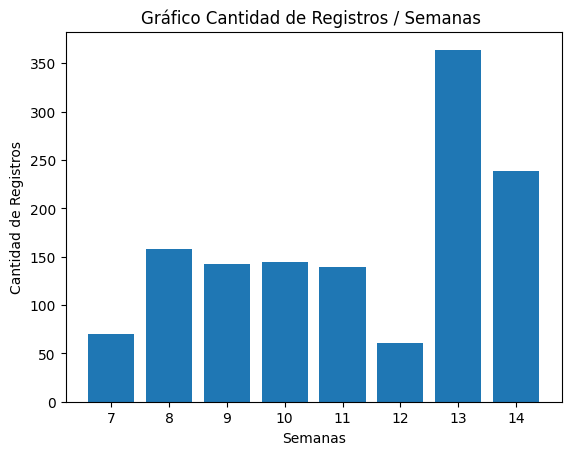

In [87]:
data_frame_p = area_perimetro(-34.164999,-64.07001,1.09)
data_frame_p2 = data_frame_p.groupby(['UUID',data_frame_p['createdAt'].dt.week]).agg({'createdAt':'count'})
data_frame_p2 = data_frame_p2.dropna()
index = [x[1] for x in data_frame_p2.index]

# Obtener los datos de las columnas 'UUID' y 'createdAt'
x = index
y = data_frame_p2['createdAt']

# Crear un gráfico de dispersión
plt.bar(x,y)
# Etiquetar los ejes y dar un título al gráfico
plt.xlabel('Semanas')
plt.ylabel('Cantidad de Registros')
plt.title('Gráfico Cantidad de Registros / Semanas ')

# Mostrar el gráfico
plt.show()